<a href="https://colab.research.google.com/github/ganeshbmc/GenAI_Math/blob/main/GAN_Deep_Convolutional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Steps  
1. Import libraries  
2. Prepare data  
   ```Download  |  Transform  |  Dataloader```  
3. Define parameters  
   ```Model  |  Optimizer  |  Loss  |  Training  ```
4. Build Model  
   ```Components  ```
5. Training loop  
6. Visualize results  

## Import libraries  

In [36]:
# import sys
# print(sys.executable)
# !{sys.executable} -m pip install seaborn

In [37]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import datetime

print(f"Imports completed at {datetime.datetime.now()}")

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Versions
print(f"Torch: {torch.__version__}, TorchVision: {torchvision.__version__}")

Imports completed at 2025-08-21 14:42:59.881679
Using device: cuda
Torch: 2.5.1, TorchVision: 0.20.1


In [38]:
# Create output folder
folder_name = "dcgan_generated_images"
os.makedirs(f"{folder_name}", exist_ok=True)

## Define parameters  

In [ ]:
# Set seed for PyTorch
seed = 42
torch.manual_seed(seed)

# Data prep params
batch_size = 128

# Model params
z_dim = 100     # Size of noise vector
img_dim = 28 * 28 # MNIST size

# Optimizer params
learning_rate = 0.0002
# beta1 = 0.5  # Adam optimizer beta1

# # Loss params
# criterion = nn.BCELoss()

# Training params
num_epochs = 100
generator_rounds = 5
discriminator_rounds = 1

## Prepare data  

In [40]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
print(f"Transform to be applied:\n{transform}\n")

# Load MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
print(f"Train data:\n{train_dataset}\n")

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # Last batch will be 96 (6000 % 128) instead of 128, so drop to avoid problem with batch norm
print(f"Data loader:\n{train_loader}")

Transform to be applied:
Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

Train data:
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

Data loader:


## Build Model  
```Deep Convolutional GAN```  
- CNN as neural network  

Generator
- noise_dim -> transpose convolutions -> img_dim (1, 28, 28) with ReLU and Tanh  

Discriminator
- img_dim (1, 28, 28) -> normal convolutions -> 1 with Sigmoid activation  

In [41]:
# Generator
class Generator(nn.Module):
  def __init__(self, noise_dim, img_dim):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        # CNN
        # Input: (N, z_dim, 1, 1)
        nn.ConvTranspose2d(z_dim, 256, 7, 1, 0, bias=False),  # Output: (N, 256, 7, 7)
        nn.BatchNorm2d(256),
        nn.ReLU(True),

        # Input: (N, 256, 7, 7)
        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),    # Output: (N, 128, 14, 14)
        nn.BatchNorm2d(128),
        nn.ReLU(True),

        # Input: (N, 128, 14, 14)
        nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),      # Output: (N, 1, 28, 28)

        # Input: (N, 1, 28, 28)
        nn.Tanh()   # Because we normalized images to [-1, 1] # Output: (N, 1, 28, 28)
    )

  def forward(self, z):
    return self.model(z)

In [42]:
generator = Generator(noise_dim=z_dim, img_dim=img_dim).to(device)
generator

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [43]:
# Discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        # Input: (N, 1, 28, 28)
        nn.Conv2d(1, 64, 4, 2, 1, bias=False),  # Output Shape: (N, 64, 14, 14)
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # Output Shape: (N, 128, 7, 7)
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Flatten(),         # Needed before passing image (2D structure) to a linear layer
        nn.Linear(128 * 7 * 7, 1),
        nn.Sigmoid()    # Outputs probability between 0 and 1
    )

  def forward(self, img):
    return self.model(img)

In [44]:
discriminator = Discriminator().to(device)
discriminator

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=6272, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

## Set up Optimizers  

In [45]:
g_optim = optim.Adam(generator.parameters(), lr=learning_rate)
g_optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)

In [46]:
d_optim = optim.Adam(discriminator.parameters(), lr=learning_rate)
d_optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)

## Set up Loss functions  

In [47]:
criterion = nn.BCELoss()
criterion

BCELoss()

## Code for visualizations  

In [48]:
def save_n_show_generated_images(epoch, generator, folder_name=folder_name):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(64, z_dim, 1, 1, device=device)
        # labels = torch.arange(0, 10, dtype=torch.long, device=device)   # Create 
        samples = generator(z)
        samples = samples * 0.5 + 0.5  # Denormalize

        # Save the images
        save_image(samples, f"{folder_name}/epoch_{epoch}.png", nrow=8)

        # Display the images
        grid = torchvision.utils.make_grid(samples, nrow=8)
        plt.figure(figsize=(8,  8))
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title(f'Generated Digits (Epoch {epoch})')
        plt.axis('off')
        plt.show()

    generator.train()

## Training loop  
- Visualize results every 10 epochs  

In [49]:
def gan_trainer(train_loader, num_epochs=20, discriminator_rounds=1, generator_rounds=1):
  fixed_noise = torch.randn(64, z_dim, 1, 1).to(device)  # For consistent visualization (Note the dimensions of fixed noise for conv operations)

  # Training loop
  for epoch in range(num_epochs):
    for batch_idx, (real, label) in enumerate(train_loader):  # We will not be using MNIST class label for GAN training
      batch_size = real.size(0)
      real = real.to(device)    # No need to reshape as it is already (N, 1, 28, 28) as needed for conv layers

      ## Create real and fake labels (note that these are not MNIST class labels. Just labels which tell if image is fake or real)
      real_labels = torch.ones(batch_size, 1).to(device)
      fake_labels = torch.zeros(batch_size, 1).to(device)

      ### ====================================
      ### 1. Train Discriminator
      ### ====================================
      for _ in range(discriminator_rounds):
        # Real images and loss
        outputs = discriminator(real)
        d_loss_real = criterion(outputs, real_labels)
        # real_score = outputs

        # Fake images and loss
        z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = generator(z)
        outputs = discriminator(fake.detach())    # Detach so gradients don't flow into generator
        d_loss_fake = criterion(outputs, fake_labels)
        # fake_score = outputs

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake

        # Update Discriminator params
        discriminator.zero_grad()
        d_loss.backward()
        d_optim.step()

      ### ====================================
      ### 2. Train Generator
      ### ====================================
      for _ in range(generator_rounds):
        # Generate fake images again
        z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = generator(z)
        outputs = discriminator(fake)

        g_loss = criterion(outputs, real_labels)  # trick discriminator

        # Update Generator params
        generator.zero_grad()
        g_loss.backward()
        g_optim.step()


    # Visualize
    if (epoch+1) % 10 == 0:
      print(f"Epoch: [{epoch+1}/{num_epochs}]")
      print(f"Size of real images: {real.size()}")
      print(f"Discriminator loss = {d_loss.item():.4f}")
      print(f"Generator loss = {g_loss.item():.4f}")
      save_n_show_generated_images(epoch=epoch+1, generator=generator)

## Training  

In [50]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

Epoch: [10/20]
Size of real images: torch.Size([128, 1, 28, 28])
Discriminator loss = 0.6145
Generator loss = 2.1343


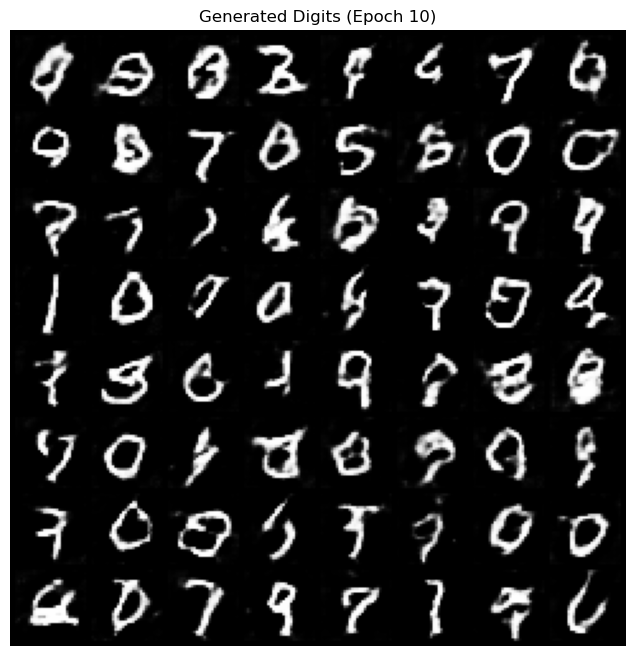

KeyboardInterrupt: 

In [51]:
gan_trainer(train_loader,
            num_epochs=num_epochs,
            discriminator_rounds=discriminator_rounds,
            generator_rounds=generator_rounds
            )